In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline 

In [19]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2, line_type=1):
    """
    line_type=0 raw mode, line_type=1 extent lines
    
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # definition of arrays to calculate de averge of all lines
    # four points for the lines with positive slope and anoter 4 
    # for the lines wit negative slope
    x1_p=[] 
    y1_p=[] 
    x2_p=[]
    y2_p=[]
    x1_n=[]
    y1_n=[]
    x2_n=[]
    y2_n=[] 

    for line in lines:
        for x1,y1,x2,y2 in line:
            if(line_type==0): #raw mode
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            else: #average and extrapolation of all lines
                m = (y2-y1)/(x2-x1)
                if(abs(m) > img.shape[0]/img.shape[1]):
                    if(m<0):
                        y1=img.shape[0]
                        x1=int(x2-(y2-y1)/m)
                        y2=int((330*img.shape[0])//540) #ojo
                        x2=int((y2-y1)/m+x1)
                        x1_n.append(x1)
                        y1_n.append(y1)
                        x2_n.append(x2)
                        y2_n.append(y2)
                    else:
                        y2=img.shape[0]
                        x2=int((y2-y1)/m+x1)
                        y1=int((330*img.shape[0])//540) #ojo
                        x1=int(x2-(y2-y1)/m)
                        x1_p.append(x1)
                        y1_p.append(y1)
                        x2_p.append(x2)
                        y2_p.append(y2)
                   
    if(line_type !=0 ):
        if(len(x1_p)>0):
            x1_right=int(sum(x1_p)/len(x1_p))
            y1_right=int(sum(y1_p)/len(y1_p))
            x2_right=int(sum(x2_p)/len(x2_p))
            y2_right=int(sum(y2_p)/len(y2_p))
            cv2.line(img, (x1_right, y1_right), (x2_right, y2_right), color, 7)
    
        if(len(x1_n)>0):
            x1_left=int(sum(x1_n)/len(x1_n))
            y1_left=int(sum(y1_n)/len(y1_n))
            x2_left=int(sum(x2_n)/len(x2_n))
            y2_left=int(sum(y2_n)/len(y2_n))
            cv2.line(img, (x1_left, y1_left), (x2_left, y2_left), color, 7)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, line_type):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines,[255, 0, 0],2,line_type)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)



In [69]:
#reading all test images and generate a list of images
image_names = os.listdir("test_images/")
images=[]
for image_name in image_names:
    image = mpimg.imread("test_images/"+image_name)
    images.append(image)


In [74]:
def process_image(image, line_type=1):
    #---------- DEFINE THE VERTICES OF THE MASKING AREA -------
    # define the vertices of the masking region for the size of 960x540 pixels
    # then the same proportion is used with another sizes of images (challenge.mp4)
    left_bottom=[(100*image.shape[1])//960,image.shape[0]]
    left_top=[(450*image.shape[1])//960,(330*image.shape[0])//540]
    right_top=[(540*image.shape[1])//960,(330*image.shape[0])//540]
    right_bottom=[(940*image.shape[1])//960,image.shape[0]]
      
    #-------EDGE DETECTION PARAMETERS------
    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 3  # Must be an odd number (3, 5, 7...)
    # Define our parameters for Canny and run it
    low_threshold = 50
    high_threshold = 200 

    #--------HOUGH TRANFORMATION ----------------
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2#4 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20      # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 60   #minimum number of pixels making up a line
    max_line_gap = 35   # maximum gap in pixels between connectable line segments
    ignore_mask_color = 255   
    
    #generating grayscale image
    gray_image = grayscale(image)
       
    #edge detection
    blur_gray = gaussian_blur(gray_image, kernel_size)
    edges_image = canny(blur_gray, low_threshold, high_threshold)

    #masking the image
    vertices = np.array([[(left_bottom[0],left_bottom[1]),(left_top[0], left_top[1]), (right_top[0], right_top[1]), (right_bottom[0],right_bottom[1])]], dtype=np.int32)
    masked_edges = region_of_interest(edges_image, vertices)
   
        
    #Hough Transformation
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, line_type)
      
    # mix the original image with the black image with lines 
    image_edges = weighted_img(line_image, image, 0.8, 1., 0.)
   
    # this line is useful to check the size of masking region for all images. it is not needed for the final pipeline. Only works with the original function draw_lines()
    # uncomment to test the making area
    #draw_lines(image_edges, np.array([[(left_bottom[0],left_bottom[1],left_top[0], left_top[1]), (left_top[0], left_top[1], right_top[0], right_top[1]), ( right_top[0], right_top[1], right_bottom[0],right_bottom[1])]]), [0, 0, 255], 3,0)
     
    return image_edges;

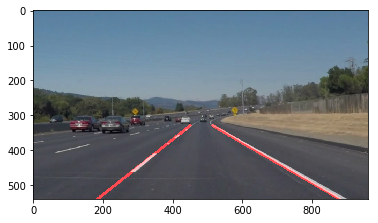

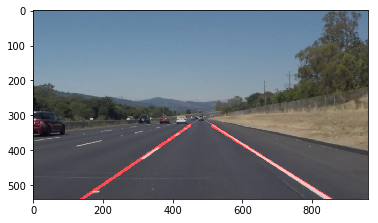

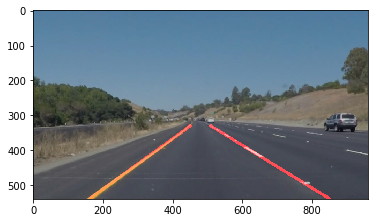

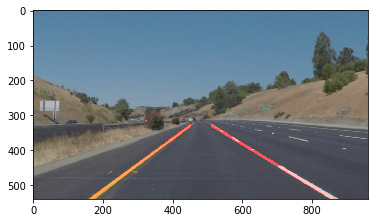

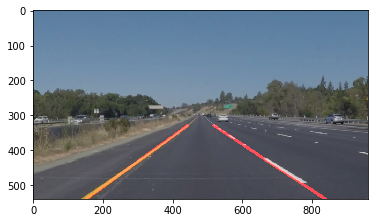

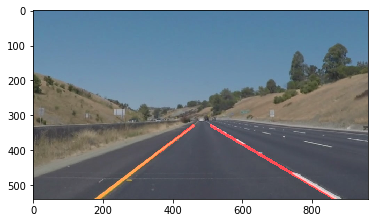

In [51]:
# test the pipeline with all the image tests comparing with the maskign area
for image in images:
    plt.figure();
    plt.imshow(process_image(image,1)) 
    
   


In [33]:
white_output = 'solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video solidWhiteRight.mp4
[MoviePy] Writing video solidWhiteRight.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 221/222 [00:09<00:00, 26.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidWhiteRight.mp4 

Wall time: 10.7 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))